# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [1]:
import xarray as xr
import cf_xarray as cfxr
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37667 instead
  warnings.warn(


/proxy/37667/status


### Open the intake-esm datastore

In [3]:
datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    datastore_path,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

### What ocean variables are available at monthly frequency?

In [4]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [5]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")
available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
KE,Layer kinetic energy per unit mass,,area:mean z_l:mean yh:mean xh:mean time: mean,m2 s-2
agessc,Ideal Age Tracer,ideal_age_tracer,area:mean z_l:mean yh:mean xh:mean time: mean,yr
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
e,Interface Height Relative to Mean Sea Level,,area:mean rho2_i:point yh:mean xh:mean time: mean,m
hfds,Surface ocean heat flux from SW+LW+latent+sens...,surface_downward_heat_flux_in_sea_water,area:mean yh:mean xh:mean time: mean,W m-2
hfrainds,Heat content (relative to 0degC) of liquid+fro...,temperature_flux_due_to_rainfall_expressed_as_...,area:mean yh:mean xh:mean time: mean,W m-2
hfrunoffds,Heat content (relative to 0C) of liquid+solid ...,temperature_flux_due_to_runoff_expressed_as_he...,area:mean yh:mean xh:mean time: mean,W m-2


### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [6]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

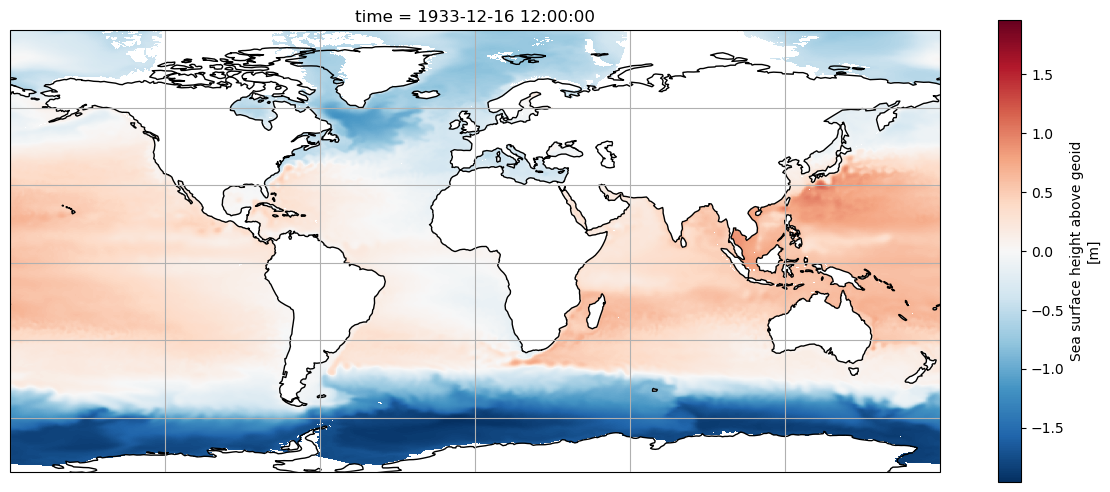

In [7]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`. We get these from a separate file which was generated without processor masking, avoiding regions on NaNs in the continents.


In [8]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset("/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc")

Now try that plot again, this time using `.cf.assign_coords` to assign `geolon` and `geolat`.

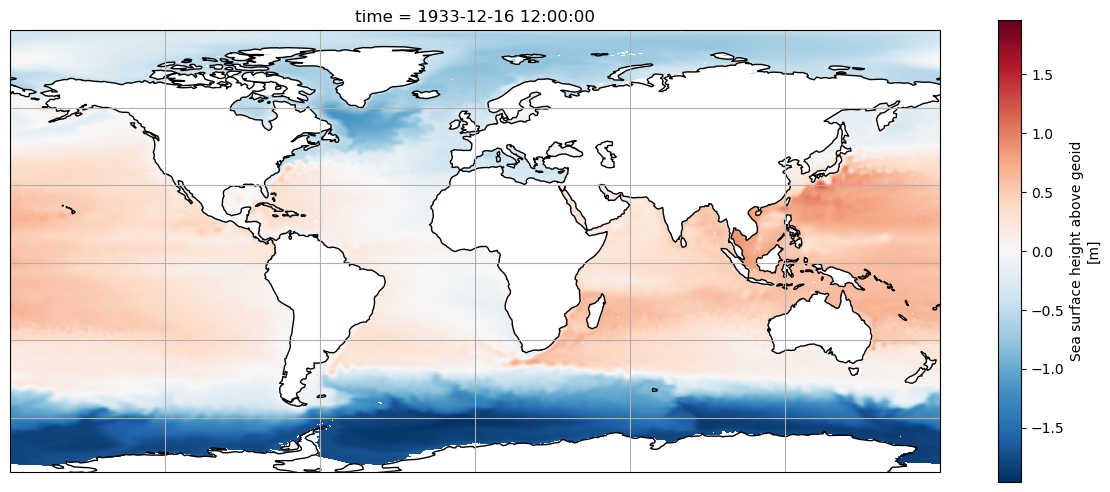

In [9]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).cf.assign_coords( { "longitude": static["geolon"],
                                              "latitude": static["geolat"] }).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

In [10]:
client.close()